<a id='logbook'></a>
# Appendix extras

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 463 ('figure.dpi       : 100        ## figure dots per inch')


In [2]:
# %load ../../notebooks/imports.py
"""
These is the standard setup for the notebooks.
"""

#from jupyterthemes import jtplot
#jtplot.style(theme='onedork', context='notebook', ticks=True, grid=False)

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import OrderedDict
plt.style.use('paper')

#import data
import copy
from mdldb.run import Run

from sklearn.pipeline import Pipeline
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
from rolldecayestimators.direct_estimator_cubic import EstimatorQuadraticB, EstimatorCubic
from rolldecayestimators.ikeda_estimator import IkedaQuadraticEstimator
import src.equations as equations
import rolldecayestimators.lambdas as lambdas
from rolldecayestimators.substitute_dynamic_symbols import lambdify
import rolldecayestimators.symbols as symbols
import sympy as sp

from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex

from sklearn.metrics import r2_score
from src.data import database
from mdldb import tables
import shipflowmotionshelpers.shipflowmotionshelpers as helpers


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
from rolldecayestimators import fit_on_amplitudes
from reports import mdl_results
import rolldecayestimators.ikeda as ikeda_classes
from pyscores2.indata import Indata
from pyscores2.output import OutputFile
import joblib
import src.visualization.visualize as visualize
from rolldecayestimators import equations_ikeda_naked
from sympy import latex
from rolldecayestimators import logarithmic_decrement
from copy import deepcopy
import src.helpers
from src.notebook_to_latex import Equation

## Examples:
from reports import mdl_results
import reports.examples as examples
import reports.examples.ikeda_V_phi_a
import reports.examples.analytical_numerical
import reports.examples.eddy_sigma
import reports.examples.ikeda_section_table
import reports.examples.decision_tree
import reports.examples.KVLCC2_section_table
import reports.examples.logaritimic_decrement
import reports.examples.mdl
from reports.examples.mdl import plot_amplitudes
import reports.examples.ikeda
import reports.examples.hybrid_0
import reports.examples.hybrid_speed
import reports.examples.FNPF
import reports.examples.KVLCC2

In [5]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf','png')
from IPython.display import HTML, Markdown, Image
from src.df_to_latex import LateXTable

## Analytical solution
<a id='analytical'></a>

<a id='eq_linear'></a>
A differential equation for a linearly decaying motion can be written as:

In [6]:
Equation(equations.diff_eq, max_length=100, label='eq:linear')

<src.notebook_to_latex.Equation object>

Which has an analytical solution <cite data-cite="undefined"></cite>:

In [7]:
Equation(equations.analytical_solution, max_length=200)

<src.notebook_to_latex.Equation object>

In the usual case of having no initial roll velocity ($\phi_0=0$) this equation can be simlified to:

In [8]:
no_initial_speed = sp.simplify(equations.analytical_solution.subs(symbols.phi_0_dot,0))
Equation(no_initial_speed)

<src.notebook_to_latex.Equation object>

And the damping coefficient $\zeta$ is very small for ships so that $\sqrt{1-\zeta}$ is almost 1 and the solution can be further simplified, into something that can easily be recognized as a decaying oscillation:

In [9]:
no_initial_speed_zeta_small = no_initial_speed.subs(
    [(sp.sqrt(1-symbols.zeta**2),1),
     (symbols.zeta*sp.sin(symbols.omega0*symbols.t),0),
    ])
Equation(no_initial_speed_zeta_small)

<src.notebook_to_latex.Equation object>

## Time and frequency domain
<a id='se_time_and_frequency'></a>
\label{se:time_and_frequency}
Ikeda's method is defined in the frequency domain, where the damping is expressed as a function of roll angle amplitude $\phi_a$ and roll angle frequency $\omega$. The equivalent linear damping $B_e$ (not to confuse with eddy damping $B_E$) is a way to convert the frequency domain damping into time domain damping <cite data-cite="7505983/FB64RGPF"></cite>, so that time domain roll simulations can be conducted with results from Ikeda's method. The most general way to determine $B_e$ is to assume that the energy loss due to damping during a half cycle of roll is the same when nonlinear and linear dampings are used <cite data-cite="7505983/RYUBZITQ"></cite>. The $B_e$ can then be calculated as a Fourier series expansion of the damping model, which in the case of a cubic model yields as: 

In [10]:
Equation(equations.B_e_equation_cubic)

<src.notebook_to_latex.Equation object>

In the case of a quadratic model $B_3=0$ and for the linear model $B_1$ and $B_e$ are the same thing.

The expression above gives a relation between the frequency domain quantities $\phi_a$, $\omega$ and the time domain quantities $B_1$, $B_2$ and $B_3$ which can be used to obtain the latter ones from the Ikeda's method. This can be done by calculating the damping with Ikeda's method for a variation of frequencies and amplitudes and then fit the above expression to this damping and obtain $B_1$, $B_2$ and $B_3$:

$$B^{Ikeda}(\phi_a, \omega) = B_e(\phi_a, \omega)$$

In the case of a roll decay test $\phi_a$ is the only parameter being varied. In order to verify this approach, an alternative method using the logaritmic decrement <cite data-cite="7505983/BYNJ8CFG"></cite> to obtaining the frequency domain quantities from time series result is also used.  

This method is investigated on simulation results with a quadratic model: $B_1 = 0.05$, $B_2 = 0.9$, $A_{44} = 1.0$, $C_1 = 5.0$. The peak values, being the only known amplitudes from this signal, is shown in the figure below.

findfont: Font family ['"serif"'] not found. Falling back to DejaVu Sans.


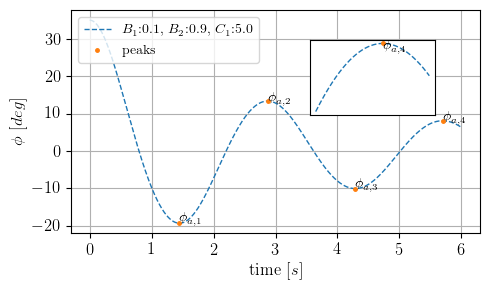

In [11]:
examples.logaritimic_decrement.show_figure_1()

The decrement is calculated as the ratio between every other peak, so that negative and positive roll peaks are separated. This decrement can be calulated for each peak:
$$ \Delta_n = \frac{\phi_{a,n}}{\phi_{a,n+2}}$$

The nondimensional $\zeta$ damping coefficient for each peak can be calculated from the logaritimic decrement:

$$\zeta_n = \frac{\delta_n}{2\pi}=\frac{ln(\Delta_n)}{2\pi}$$

The dimensional damping $B_n$ (Nm*s) can be then be obtained:

In [12]:
Equation(equations.B_1_zeta_eq.subs(symbols.B_1, symbols.B))

<src.notebook_to_latex.Equation object>

So the damping can be obtained for each oscillation this way but it is not obvious which of the roll amplitudes these dampings correspond to. Four different choices were tried, associating damping $B_n$ with the following amplitudes:
* A : $\phi_n$
* B : $\phi_{n+1}$
* C : $\phi_{n+2}$
* D : $(\phi_n + \phi_{n+1} + \phi_{n+2})/3$

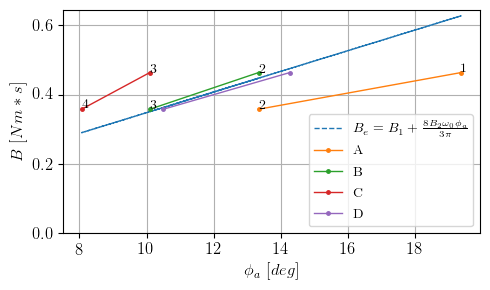

In [13]:
examples.logaritimic_decrement.show_figure_2();

Taking the mean value of peak n and the following two peaks (alt.D) seem to be the approach that best matches the $B_e$ (predicted using the linearized equivalent damping method). The  linearized equivalent damping method therefore seems to be the best way to convert $B_1$, $B_2$, $B_3$ to frequency domain, considering the difficulties with the logaritmic decrement method as described above. The only time linearized equivalent damping method has not been used in this paper, is when damping at individual peaks from a time signal should be converted to frequency domain. 

# References
<div class="cite2c-biblio"></div>